In [6]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import pandas as pd
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

In [7]:
# reading the image data from desired directory
img = cv2.imread("dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\ISIC_0024306_segmentation.png")
img.shape

(450, 600, 3)

In [8]:

# reading the image data from desired directory
img = cv2.imread("dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\ISIC_0025279_segmentation.png")
img.shape

(450, 600, 3)

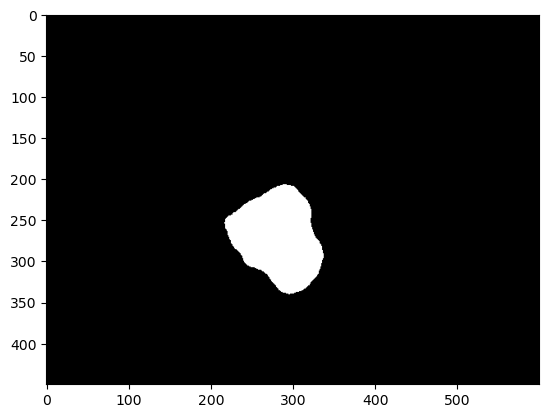

In [9]:
plt.imshow(img)

In [10]:
# counting the number of pixels
number_of_white_pix = np.sum(img == 255)
number_of_black_pix = np.sum(img == 0)
  
print('Number of white pixels:', number_of_white_pix)
print('Number of black pixels:', number_of_black_pix)

Number of white pixels: 31167
Number of black pixels: 778833


In [12]:
basepath = "dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\\"

path = glob.glob(basepath+"*.png")

In [13]:
ratio = []
for img in path:
    n = cv2.imread(img)
    wp=np.sum(n == 255)
    bp=np.sum(n == 0)
    ratio.append(wp/(wp+bp))

C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


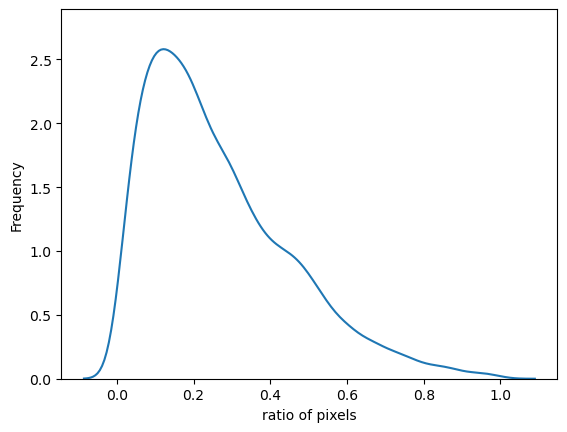

In [15]:
# plotting a histogram
ax = sns.distplot(ratio,
                  bins=100,
                  kde=True,
                  #color='none',
                  hist_kws={"linewidth": 15,'alpha':0})
ax.set(xlabel='ratio of pixels', ylabel='Frequency')
 
plt.show()

### Distribution of each class

In [252]:
skin_df = pd.read_csv('dataverse_files\HAM10000_metadata', sep='\t', encoding='latin')

In [253]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [254]:
skin_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [255]:
skin_df['image_id_seg'] =skin_df['image_id']+"_segmentation.png"

In [256]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_id_seg
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,ISIC_0027419_segmentation.png
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,ISIC_0025030_segmentation.png
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,ISIC_0026769_segmentation.png
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,ISIC_0025661_segmentation.png
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,ISIC_0031633_segmentation.png
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,ISIC_0033084_segmentation.png
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,ISIC_0033550_segmentation.png
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,ISIC_0033536_segmentation.png
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,ISIC_0032854_segmentation.png


### Class Balancing

In [257]:
df_nv = skin_df[skin_df['dx']=='nv']
df_mel = skin_df[skin_df['dx']=='mel']
df_bkl = skin_df[skin_df['dx']=='bkl']
df_bcc = skin_df[skin_df['dx']=='bcc']
df_akiec = skin_df[skin_df['dx']=='akiec']
df_vasc = skin_df[skin_df['dx']=='vasc']
df_df = skin_df[skin_df['dx']=='df']

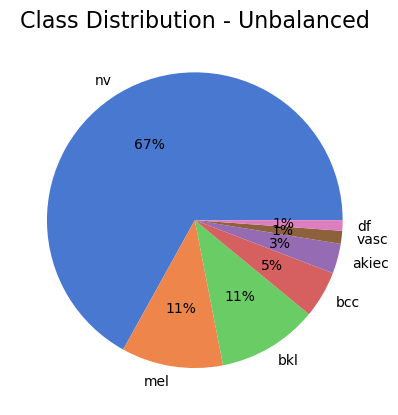

In [262]:
#define Seaborn color palette to use
colors = sns.color_palette('muted')[0:7]

#create pie chart
plt.pie([df_nv.shape[0],df_mel.shape[0],df_bkl.shape[0], df_bcc.shape[0],df_akiec.shape[0],df_vasc.shape[0],df_df.shape[0]], labels = ['nv','mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], colors = colors, autopct='%.0f%%')
plt.title( "Class Distribution - Unbalanced" , size = 16 )
plt.show()

In [259]:
n_samples=500 
df_nv_balanced = resample(df_nv, replace=True, n_samples=n_samples, random_state=42) 
df_mel_balanced = resample(df_mel, replace=True, n_samples=n_samples, random_state=42) 
df_bkl_balanced = resample(df_bkl, replace=True, n_samples=n_samples, random_state=42)
df_bcc_balanced = resample(df_bcc, replace=True, n_samples=n_samples, random_state=42)
df_akiec_balanced = resample(df_akiec, replace=True, n_samples=n_samples, random_state=42)
df_vasc_balanced = resample(df_vasc, replace=True, n_samples=n_samples, random_state=42)
df_df_balanced = resample(df_df, replace=True, n_samples=n_samples, random_state=42)

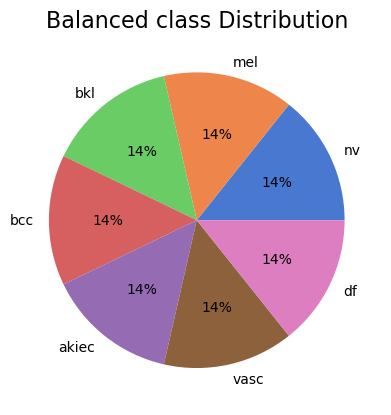

In [261]:
#define Seaborn color palette to use
colors = sns.color_palette('muted')[0:7]

#create pie chart
plt.pie([df_nv_balanced.shape[0],df_mel_balanced.shape[0],df_bkl_balanced.shape[0], df_bcc_balanced.shape[0],df_akiec_balanced.shape[0],
         df_vasc_balanced.shape[0],df_df_balanced.shape[0]], labels = ['nv','mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], colors = colors, autopct='%.0f%%')
plt.title( "Balanced class Distribution" , size = 16 )
plt.show()

In [180]:
df_nv_balanced.shape

(500, 9)

In [183]:
skin_df = pd.concat([df_nv_balanced, df_mel_balanced, 
                              df_bkl_balanced, df_bcc_balanced, 
                              df_akiec_balanced, df_vasc_balanced, df_df_balanced])

In [184]:
print(skin_df['dx'].value_counts())

nv       500
mel      500
bkl      500
bcc      500
akiec    500
vasc     500
df       500
Name: dx, dtype: int64


In [185]:
df_array = ['nv','mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

In [186]:
def get_proportion_of_whitepixels(img_path):
    n = cv2.imread(img_path)
    wp=np.sum(n == 255)
    bp=np.sum(n == 0)
    return (wp/(wp+bp))

In [187]:
basepath = "dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\\"
proportion_dict = {}
for cl in df_array:
    df= skin_df[skin_df['dx']==cl]
    ratio = []
    for i, row in df.iterrows():
        ratio.append(get_proportion_of_whitepixels(os.path.join(basepath, row['image_id_seg'])))
    proportion_dict[cl] = ratio
    

In [188]:
proportion_dict.keys()

dict_keys(['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'])

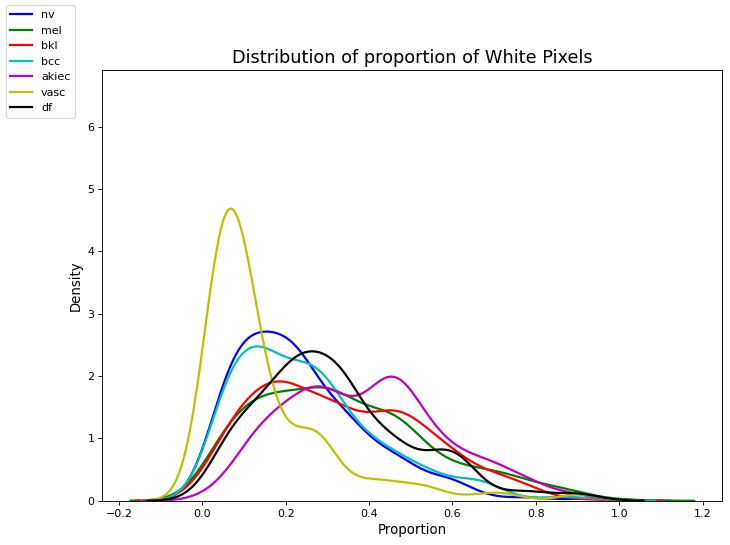

In [207]:
fig = plt.figure(figsize=(10,7), dpi = 80)
sns.distplot(proportion_dict['nv'], color="b",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['mel'], color="g",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['bkl'], color="r",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['bcc'], color="c",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['akiec'], color="m",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['vasc'], color="y", kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(proportion_dict['df'], color="k", kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
fig.legend(labels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], loc='upper left')               
plt.title( "Distribution of proportion of White Pixels" , size = 16 )
plt.xlabel('Proportion', size = 12)
plt.ylabel('Density', size = 12)
plt.show()

### Approach 2

#### considering only the number of white pixels

In [208]:
def get_number_of_whitepixels(img_path):
    n = cv2.imread(img_path)
    wp=np.sum(n == 255)
    return wp

In [209]:
basepath = "dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\\"
wp_dict = {}
for cl in df_array:
    df= skin_df[skin_df['dx']==cl]
    wp_array = []
    for i, row in df.iterrows():
        wp_array.append(get_number_of_whitepixels(os.path.join(basepath, row['image_id_seg'])))
    wp_dict[cl] = wp_array

In [211]:
for cl in df_array:
    wp_dict[cl] =  preprocessing.normalize([wp_dict[cl]])
    

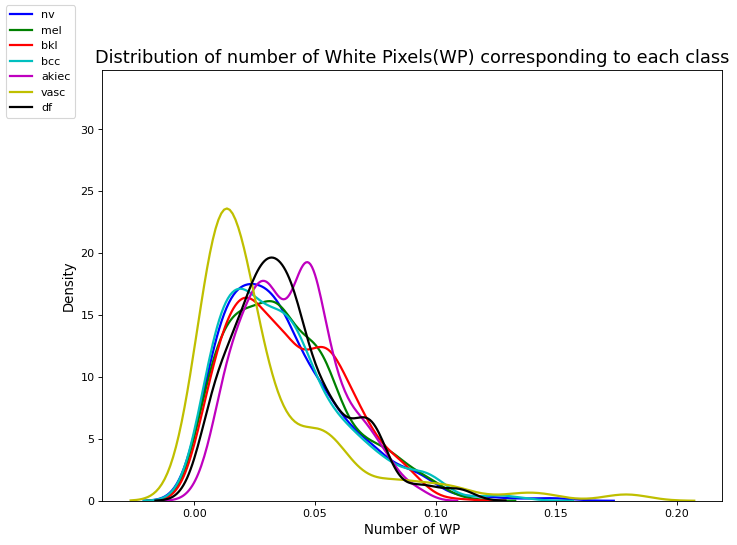

In [212]:
fig = plt.figure(figsize=(10,7), dpi = 80)
sns.distplot(wp_dict['nv'], color="b",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['mel'], color="g",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['bkl'], color="r",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['bcc'], color="c",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['akiec'], color="m",kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['vasc'], color="y", kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
sns.distplot(wp_dict['df'], color="k", kde=True, hist_kws={'alpha':0}, kde_kws={'linewidth':2})
fig.legend(labels=['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], loc='upper left')               
plt.title( "Distribution of number of White Pixels(WP) corresponding to each class" , size = 16 )
plt.xlabel('Number of WP', size = 12)
plt.ylabel('Density', size = 12)
plt.show()




### WP proportions and number of WP as columns in the data frame

In [213]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_id_seg
3835,HAM_0000474,ISIC_0030099,nv,follow_up,45.0,female,hand,vidir_molemax,ISIC_0030099_segmentation.png
8367,HAM_0000597,ISIC_0030654,nv,histo,35.0,female,abdomen,vienna_dias,ISIC_0030654_segmentation.png
8203,HAM_0007585,ISIC_0032347,nv,histo,35.0,female,back,vienna_dias,ISIC_0032347_segmentation.png
8168,HAM_0005902,ISIC_0027285,nv,histo,40.0,female,foot,vienna_dias,ISIC_0027285_segmentation.png
6747,HAM_0004380,ISIC_0026251,nv,histo,30.0,female,face,vidir_modern,ISIC_0026251_segmentation.png
...,...,...,...,...,...,...,...,...,...
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,vidir_modern,ISIC_0032410_segmentation.png
1186,HAM_0006816,ISIC_0026254,df,consensus,45.0,male,lower extremity,vidir_molemax,ISIC_0026254_segmentation.png
1192,HAM_0004496,ISIC_0028651,df,consensus,55.0,female,lower extremity,vidir_molemax,ISIC_0028651_segmentation.png
1160,HAM_0002450,ISIC_0024396,df,consensus,65.0,female,lower extremity,vidir_modern,ISIC_0024396_segmentation.png


In [214]:
basepath = "dataverse_files\HAM10000_segmentations_lesion_tschandl\HAM10000_segmentations_lesion_tschandl\\"
skin_df['wp_count'] = None
skin_df['wp_proportion'] = None

In [215]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_id_seg,wp_count,wp_proportion
3835,HAM_0000474,ISIC_0030099,nv,follow_up,45.0,female,hand,vidir_molemax,ISIC_0030099_segmentation.png,None,None
8367,HAM_0000597,ISIC_0030654,nv,histo,35.0,female,abdomen,vienna_dias,ISIC_0030654_segmentation.png,None,None
8203,HAM_0007585,ISIC_0032347,nv,histo,35.0,female,back,vienna_dias,ISIC_0032347_segmentation.png,None,None
8168,HAM_0005902,ISIC_0027285,nv,histo,40.0,female,foot,vienna_dias,ISIC_0027285_segmentation.png,None,None
6747,HAM_0004380,ISIC_0026251,nv,histo,30.0,female,face,vidir_modern,ISIC_0026251_segmentation.png,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,vidir_modern,ISIC_0032410_segmentation.png,None,None
1186,HAM_0006816,ISIC_0026254,df,consensus,45.0,male,lower extremity,vidir_molemax,ISIC_0026254_segmentation.png,None,None
1192,HAM_0004496,ISIC_0028651,df,consensus,55.0,female,lower extremity,vidir_molemax,ISIC_0028651_segmentation.png,None,None
1160,HAM_0002450,ISIC_0024396,df,consensus,65.0,female,lower extremity,vidir_modern,ISIC_0024396_segmentation.png,None,None


In [216]:
for i, row in skin_df.iterrows():
    path = os.path.join(basepath, row['image_id_seg'])
    n = cv2.imread(path)
    wp=np.sum(n == 255)
    bp=np.sum(n == 0)
    skin_df.loc[i,'wp_count'] = wp
    skin_df.loc[i, 'wp_proportion'] = wp/(wp+bp)

In [217]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_id_seg,wp_count,wp_proportion
3835,HAM_0000474,ISIC_0030099,nv,follow_up,45.0,female,hand,vidir_molemax,ISIC_0030099_segmentation.png,74109,0.091493
8367,HAM_0000597,ISIC_0030654,nv,histo,35.0,female,abdomen,vienna_dias,ISIC_0030654_segmentation.png,220635,0.272389
8203,HAM_0007585,ISIC_0032347,nv,histo,35.0,female,back,vienna_dias,ISIC_0032347_segmentation.png,204039,0.2519
8168,HAM_0005902,ISIC_0027285,nv,histo,40.0,female,foot,vienna_dias,ISIC_0027285_segmentation.png,169686,0.209489
6747,HAM_0004380,ISIC_0026251,nv,histo,30.0,female,face,vidir_modern,ISIC_0026251_segmentation.png,4908,0.006059
...,...,...,...,...,...,...,...,...,...,...,...
1109,HAM_0005518,ISIC_0032410,df,histo,30.0,male,lower extremity,vidir_modern,ISIC_0032410_segmentation.png,367002,0.453089
1186,HAM_0006816,ISIC_0026254,df,consensus,45.0,male,lower extremity,vidir_molemax,ISIC_0026254_segmentation.png,221061,0.272915
1192,HAM_0004496,ISIC_0028651,df,consensus,55.0,female,lower extremity,vidir_molemax,ISIC_0028651_segmentation.png,144831,0.178804
1160,HAM_0002450,ISIC_0024396,df,consensus,65.0,female,lower extremity,vidir_modern,ISIC_0024396_segmentation.png,51189,0.063196


In [218]:
extracted_df = skin_df[['age', 'sex', 'localization','dx_type', 'wp_count', 'wp_proportion', 'dx',]]

In [219]:
extracted_df

,age,sex,localization,dx_type,wp_count,wp_proportion,dx
3835,45.0,female,hand,follow_up,74109,0.091493,nv
8367,35.0,female,abdomen,histo,220635,0.272389,nv
8203,35.0,female,back,histo,204039,0.2519,nv
8168,40.0,female,foot,histo,169686,0.209489,nv
6747,30.0,female,face,histo,4908,0.006059,nv
...,...,...,...,...,...,...,...
1109,30.0,male,lower extremity,histo,367002,0.453089,df
1186,45.0,male,lower extremity,consensus,221061,0.272915,df
1192,55.0,female,lower extremity,consensus,144831,0.178804,df
1160,65.0,female,lower extremity,consensus,51189,0.063196,df


In [243]:
extracted_df_heatmap = extracted_df.copy()

In [245]:
extracted_df_heatmap['dx']= extracted_df_heatmap['dx'].map({'nv':0, 'mel':1, 'bkl':2, 'bcc':3, 'akiec':4, 'vasc':5, 'df':6})

In [248]:
extracted_df_heatmap.dtypes

age                             float64
wp_count                         object
wp_proportion                    object
dx                                int64
sex_female                        uint8
sex_male                          uint8
sex_unknown                       uint8
localization_abdomen              uint8
localization_acral                uint8
localization_back                 uint8
localization_chest                uint8
localization_ear                  uint8
localization_face                 uint8
localization_foot                 uint8
localization_genital              uint8
localization_hand                 uint8
localization_lower extremity      uint8
localization_neck                 uint8
localization_scalp                uint8
localization_trunk                uint8
localization_unknown              uint8
localization_upper extremity      uint8
dx_type_confocal                  uint8
dx_type_consensus                 uint8
dx_type_follow_up                 uint8


<AxesSubplot:>

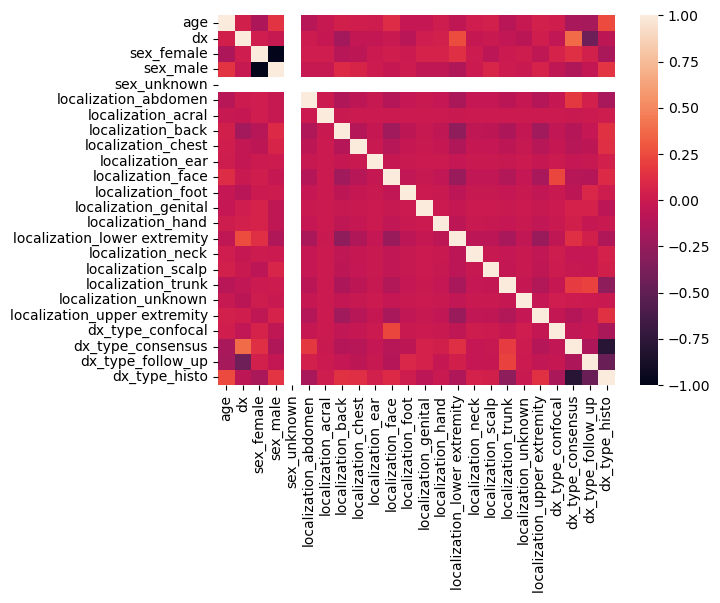

In [251]:
sns.heatmap(extracted_df_heatmap.corr())

In [220]:
extracted_df = pd.get_dummies(extracted_df, columns = ['sex', 'localization', 'dx_type'])

In [221]:
extracted_df.isnull().values.any()

True

In [222]:
extracted_df.isnull().sum()

age                             12
wp_count                         0
wp_proportion                    0
dx                               0
sex_female                       0
sex_male                         0
sex_unknown                      0
localization_abdomen             0
localization_acral               0
localization_back                0
localization_chest               0
localization_ear                 0
localization_face                0
localization_foot                0
localization_genital             0
localization_hand                0
localization_lower extremity     0
localization_neck                0
localization_scalp               0
localization_trunk               0
localization_unknown             0
localization_upper extremity     0
dx_type_confocal                 0
dx_type_consensus                0
dx_type_follow_up                0
dx_type_histo                    0
dtype: int64

In [223]:
extracted_df = extracted_df.dropna()

In [224]:
extracted_df.isnull().values.any()

False

### KNN

In [226]:
y= extracted_df[["dx"]]
X = extracted_df.drop('dx', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size = 0.2, random_state = 1)

In [227]:
#Checking with KNN

clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.3438395415472779


In [228]:
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names = y.dx.unique())
print(report)

              precision    recall  f1-score   support

          nv       0.32      0.46      0.38       103
         mel       0.22      0.19      0.20       102
         bkl       0.27      0.17      0.20       102
         bcc       0.45      0.63      0.53        98
       akiec       0.25      0.20      0.22       101
        vasc       0.23      0.14      0.17       100
          df       0.50      0.66      0.57        92

    accuracy                           0.34       698
   macro avg       0.32      0.35      0.33       698
weighted avg       0.32      0.34      0.32       698



### Random Forest

In [230]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

In [231]:
report = classification_report(y_test, y_pred, target_names = y.dx.unique())
print(report)

              precision    recall  f1-score   support

          nv       0.74      0.82      0.77       103
         mel       0.68      0.68      0.68       102
         bkl       0.67      0.55      0.60       102
         bcc       0.90      0.98      0.94        98
       akiec       0.62      0.57      0.59       101
        vasc       0.78      0.74      0.76       100
          df       0.86      0.97      0.91        92

    accuracy                           0.75       698
   macro avg       0.75      0.76      0.75       698
weighted avg       0.75      0.75      0.75       698



### Gaussian Naive Bayes


In [233]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names = y.dx.unique())
print(report)

              precision    recall  f1-score   support

          nv       0.28      0.44      0.34       103
         mel       0.25      0.52      0.34       102
         bkl       1.00      0.01      0.02       102
         bcc       0.23      0.22      0.23        98
       akiec       0.20      0.01      0.02       101
        vasc       0.38      0.42      0.40       100
          df       0.40      0.50      0.44        92

    accuracy                           0.30       698
   macro avg       0.39      0.30      0.26       698
weighted avg       0.39      0.30      0.25       698

